# Практическое задание №5

В современном мире есть много различных устройств (фитнес-браслетов, камер, датчиков и пр.), которые собирают данные об активности пользователя. Эти сведения могут быть использованы, например, для отслеживания состояния здоровья человека и определение находится ли он сейчас в безопасности, что он делает, и так далее.

Данные, собранные с носимых устройств, которые отслеживают физическую активность пользователей, используются во множестве коммерческих приложений, включая здравоохранение, фитнес-тренировки, навигационную систему и так далее.

В данной задаче вам предлагается, используя информацию, собранную с помощью трех инерциальных измерительных модуля (IMU) и пульсометра, кластеризовать данные на группы по типу активности (например, бег, ходьба, сон и пр.).

In [1]:
!pip install opendatasets --quiet

In [ ]:
%load_ext cuml.accel

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [21]:
import opendatasets as od
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors

### Исследование и анализ датасета.

In [4]:
od.download('https://www.kaggle.com/competitions/clustering-physical-activity-data')

Skipping, found downloaded files in "./clustering-physical-activity-data" (use force=True to force download)


In [5]:
df = pd.read_csv('./clustering-physical-activity-data/Physical_Activity_Monitoring_unlabeled.csv')

In [6]:
df

,timestamp,handTemperature,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,handGyro1,handGyro2,...,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3,ankleOrientation1,ankleOrientation2,ankleOrientation3,ankleOrientation4,subject_id
0,252.75,34.8750,0.902847,7.45872,6.032490,1.006100,7.44575,6.303650,-0.021952,0.004114,...,-0.025606,0.030239,-14.54470,27.3336,-5.766200,0.206416,0.348212,0.763201,-0.503652,5
1,3652.45,29.7500,-4.069330,3.76168,8.279720,-5.972500,3.22273,6.908970,0.116054,-0.375968,...,-0.670163,1.786200,-32.82570,-15.7719,-1.313950,0.578332,-0.566734,0.405888,-0.423791,2
2,504.76,34.3750,-2.007540,-9.60180,0.773674,-1.803500,-9.58937,1.073680,0.020131,0.042189,...,-0.009741,-0.006579,-18.81710,16.3089,25.292800,0.139776,0.676586,0.393796,0.606316,8
3,2801.61,31.9375,-13.262200,5.85443,0.899334,-13.611500,5.91511,0.840377,1.715630,-0.050492,...,-0.163470,-3.495570,-26.74180,34.3566,21.327400,0.416303,0.783387,0.306464,0.345075,2
4,441.01,33.5000,-0.013940,8.66540,4.398210,0.144153,8.56816,4.822200,-0.006938,-0.007383,...,-0.028172,-0.003737,-17.77980,-3.9981,10.995000,0.171133,-0.748343,0.252988,-0.588807,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534596,3479.53,33.8750,-9.084250,4.70122,2.890170,-9.689610,6.78077,3.975430,-0.157406,0.774189,...,0.424520,-0.856836,-25.00990,-23.5557,23.615300,0.318171,-0.701921,0.555778,-0.311745,5
534597,2448.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.767710,-3.050980,-35.70240,31.8018,16.421800,0.435887,0.660643,0.371665,0.485200,5
534598,2479.84,34.6875,-6.367550,2.32131,2.207640,-6.362460,2.33049,2.607610,0.206349,-0.359415,...,-0.034144,-0.402013,-49.69220,20.6039,-0.917908,0.561652,0.297957,0.756767,0.151899,5
534599,3437.82,28.0625,5.461940,10.43640,-9.073300,8.348860,5.76518,-6.143210,3.543910,2.757300,...,0.352062,-5.577750,-34.15510,-11.0786,39.737500,0.062163,-0.798705,-0.056668,-0.595815,6


In [7]:
print(f"Размеры  датасета: {df.shape}")

Размеры  датасета: (534601, 53)


In [8]:
df.describe(include='all')

,timestamp,handTemperature,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,handGyro1,handGyro2,...,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3,ankleOrientation1,ankleOrientation2,ankleOrientation3,ankleOrientation4,subject_id
count,534601.000000,530560.000000,530560.000000,530560.000000,530560.000000,530560.000000,530560.000000,530560.000000,530560.000000,530560.000000,...,532055.000000,532055.000000,532055.000000,532055.000000,532055.000000,532055.000000,532055.000000,532055.000000,532055.000000,534601.000000
mean,1593.538159,32.451221,-4.435286,3.241949,4.079375,-4.375896,3.218250,4.262513,-0.008852,0.028801,...,-0.031911,0.002304,-28.756284,2.115624,14.723345,0.360159,-0.091093,0.303517,-0.173845,4.558615
std,1243.906483,1.754847,7.062004,7.224031,3.831257,7.068961,6.864782,3.822053,1.160112,0.926832,...,0.618840,2.036102,19.303887,22.253170,17.907491,0.301254,0.559400,0.344271,0.466304,2.318076
min,37.660000,27.500000,-114.755000,-82.550900,-73.949700,-61.214700,-61.824200,-61.577100,-19.690500,-7.609010,...,-7.701040,-14.019600,-172.865000,-136.951000,-102.716000,0.000003,-0.954848,-0.876838,-0.997040,1.000000
25%,475.500000,31.312500,-9.076360,0.682775,1.588777,-8.981072,0.687587,1.780160,-0.153182,-0.083315,...,-0.049003,-0.221911,-39.689950,-10.960850,2.252230,0.145023,-0.676392,0.006839,-0.580040,2.000000
50%,827.610000,32.875000,-5.465610,3.089205,4.157125,-5.434845,3.127145,4.413625,-0.004439,0.004013,...,-0.004481,0.000354,-26.285600,-0.014372,16.599500,0.240996,0.000000,0.322698,-0.281681,5.000000
75%,2876.990000,33.812500,0.383679,5.559742,6.864212,0.424770,5.592180,7.148178,0.130310,0.094342,...,0.048972,0.032649,-14.549500,19.245900,25.947100,0.501671,0.410052,0.594198,0.252247,7.000000
max,4007.730000,35.250000,60.912600,155.532000,78.480100,34.159400,62.259800,60.843700,22.960000,11.862600,...,6.002540,14.482700,41.764800,92.867000,122.521000,1.000000,0.959538,0.920506,0.996105,8.000000


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534601 entries, 0 to 534600
Data columns (total 53 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   timestamp          534601 non-null  float64
 1   handTemperature    530560 non-null  float64
 2   handAcc16_1        530560 non-null  float64
 3   handAcc16_2        530560 non-null  float64
 4   handAcc16_3        530560 non-null  float64
 5   handAcc6_1         530560 non-null  float64
 6   handAcc6_2         530560 non-null  float64
 7   handAcc6_3         530560 non-null  float64
 8   handGyro1          530560 non-null  float64
 9   handGyro2          530560 non-null  float64
 10  handGyro3          530560 non-null  float64
 11  handMagne1         530560 non-null  float64
 12  handMagne2         530560 non-null  float64
 13  handMagne3         530560 non-null  float64
 14  handOrientation1   530560 non-null  float64
 15  handOrientation2   530560 non-null  float64
 16  ha

Датасет содержит по 53 столбца на строку, столбцы содержат следующие данные:

- 0 временная метка (с)
- 1-17 данные с датчиков на руке
- 18-34 данные с датчиков на груди
- 35-51 данные с датчиков на лодыжке
- 52 айди субъекта наблюдения

In [10]:
df.columns

Index(['timestamp', 'handTemperature', 'handAcc16_1', 'handAcc16_2',
       'handAcc16_3', 'handAcc6_1', 'handAcc6_2', 'handAcc6_3', 'handGyro1',
       'handGyro2', 'handGyro3', 'handMagne1', 'handMagne2', 'handMagne3',
       'handOrientation1', 'handOrientation2', 'handOrientation3',
       'handOrientation4', 'chestTemperature', 'chestAcc16_1', 'chestAcc16_2',
       'chestAcc16_3', 'chestAcc6_1', 'chestAcc6_2', 'chestAcc6_3',
       'chestGyro1', 'chestGyro2', 'chestGyro3', 'chestMagne1', 'chestMagne2',
       'chestMagne3', 'chestOrientation1', 'chestOrientation2',
       'chestOrientation3', 'chestOrientation4', 'ankleTemperature',
       'ankleAcc16_1', 'ankleAcc16_2', 'ankleAcc16_3', 'ankleAcc6_1',
       'ankleAcc6_2', 'ankleAcc6_3', 'ankleGyro1', 'ankleGyro2', 'ankleGyro3',
       'ankleMagne1', 'ankleMagne2', 'ankleMagne3', 'ankleOrientation1',
       'ankleOrientation2', 'ankleOrientation3', 'ankleOrientation4',
       'subject_id'],
      dtype='object')

In [12]:
# Посмотрим пропуски
# Количество пропусков
missing_values = df.isnull().sum()
# Общее число строк
total_rows = len(df)

print(f"Количество пропусков всего: \n{missing_values}")

Количество пропусков всего: 
timestamp               0
handTemperature      4041
handAcc16_1          4041
handAcc16_2          4041
handAcc16_3          4041
handAcc6_1           4041
handAcc6_2           4041
handAcc6_3           4041
handGyro1            4041
handGyro2            4041
handGyro3            4041
handMagne1           4041
handMagne2           4041
handMagne3           4041
handOrientation1     4041
handOrientation2     4041
handOrientation3     4041
handOrientation4     4041
chestTemperature      809
chestAcc16_1          809
chestAcc16_2          809
chestAcc16_3          809
chestAcc6_1           809
chestAcc6_2           809
chestAcc6_3           809
chestGyro1            809
chestGyro2            809
chestGyro3            809
chestMagne1           809
chestMagne2           809
chestMagne3           809
chestOrientation1     809
chestOrientation2     809
chestOrientation3     809
chestOrientation4     809
ankleTemperature     2546
ankleAcc16_1         2546
ankleAcc1

In [13]:
# Отфильтруем только столбцы с пропусками
missing_data = missing_values[missing_values > 0].to_frame(name="Missing Count")
missing_data["Missing Percentage"] = (missing_data["Missing Count"] / total_rows) * 100

missing_data

,Missing Count,Missing Percentage
handTemperature,4041,0.755891
handAcc16_1,4041,0.755891
handAcc16_2,4041,0.755891
handAcc16_3,4041,0.755891
handAcc6_1,4041,0.755891
handAcc6_2,4041,0.755891
handAcc6_3,4041,0.755891
handGyro1,4041,0.755891
handGyro2,4041,0.755891
handGyro3,4041,0.755891


In [14]:
missing_data.shape

(51, 2)

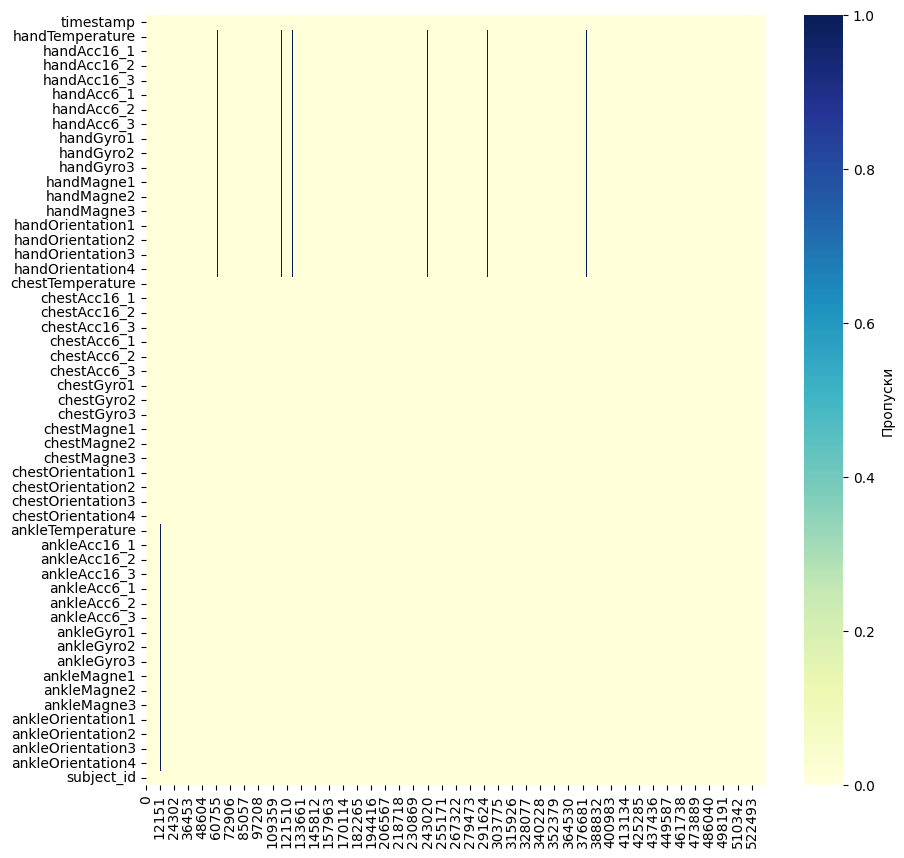

In [15]:
plt.figure(figsize=(10,10))
sns.heatmap(df.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Пропуски'})
plt.savefig("visualizing_missing_data.png", dpi=100)

In [17]:
df['subject_id'].value_counts()

,count
subject_id,
5,76793
8,73047
6,70240
1,69882
2,68740
4,63740
7,62115
3,50044


### Предобработка данных.


In [18]:
# Заполним пропуски
columns_with_nan = df.columns.difference(['timestamp', 'subject_id'])

# для каждой колонки с пропусками
for col in columns_with_nan:
    # группируем по субъекту и заполняем средним для него значением
    df[col] = df.groupby('subject_id')[col].transform(
        lambda x: x.fillna(x.mean())
    )

In [19]:
print(f"Осталось пропусков: {df.isna().sum()}")

Осталось пропусков: timestamp            0
handTemperature      0
handAcc16_1          0
handAcc16_2          0
handAcc16_3          0
handAcc6_1           0
handAcc6_2           0
handAcc6_3           0
handGyro1            0
handGyro2            0
handGyro3            0
handMagne1           0
handMagne2           0
handMagne3           0
handOrientation1     0
handOrientation2     0
handOrientation3     0
handOrientation4     0
chestTemperature     0
chestAcc16_1         0
chestAcc16_2         0
chestAcc16_3         0
chestAcc6_1          0
chestAcc6_2          0
chestAcc6_3          0
chestGyro1           0
chestGyro2           0
chestGyro3           0
chestMagne1          0
chestMagne2          0
chestMagne3          0
chestOrientation1    0
chestOrientation2    0
chestOrientation3    0
chestOrientation4    0
ankleTemperature     0
ankleAcc16_1         0
ankleAcc16_2         0
ankleAcc16_3         0
ankleAcc6_1          0
ankleAcc6_2          0
ankleAcc6_3          0
ankleGyro1    

Пропуски заполнили, все столбцы числовые. Кодировать не нужно

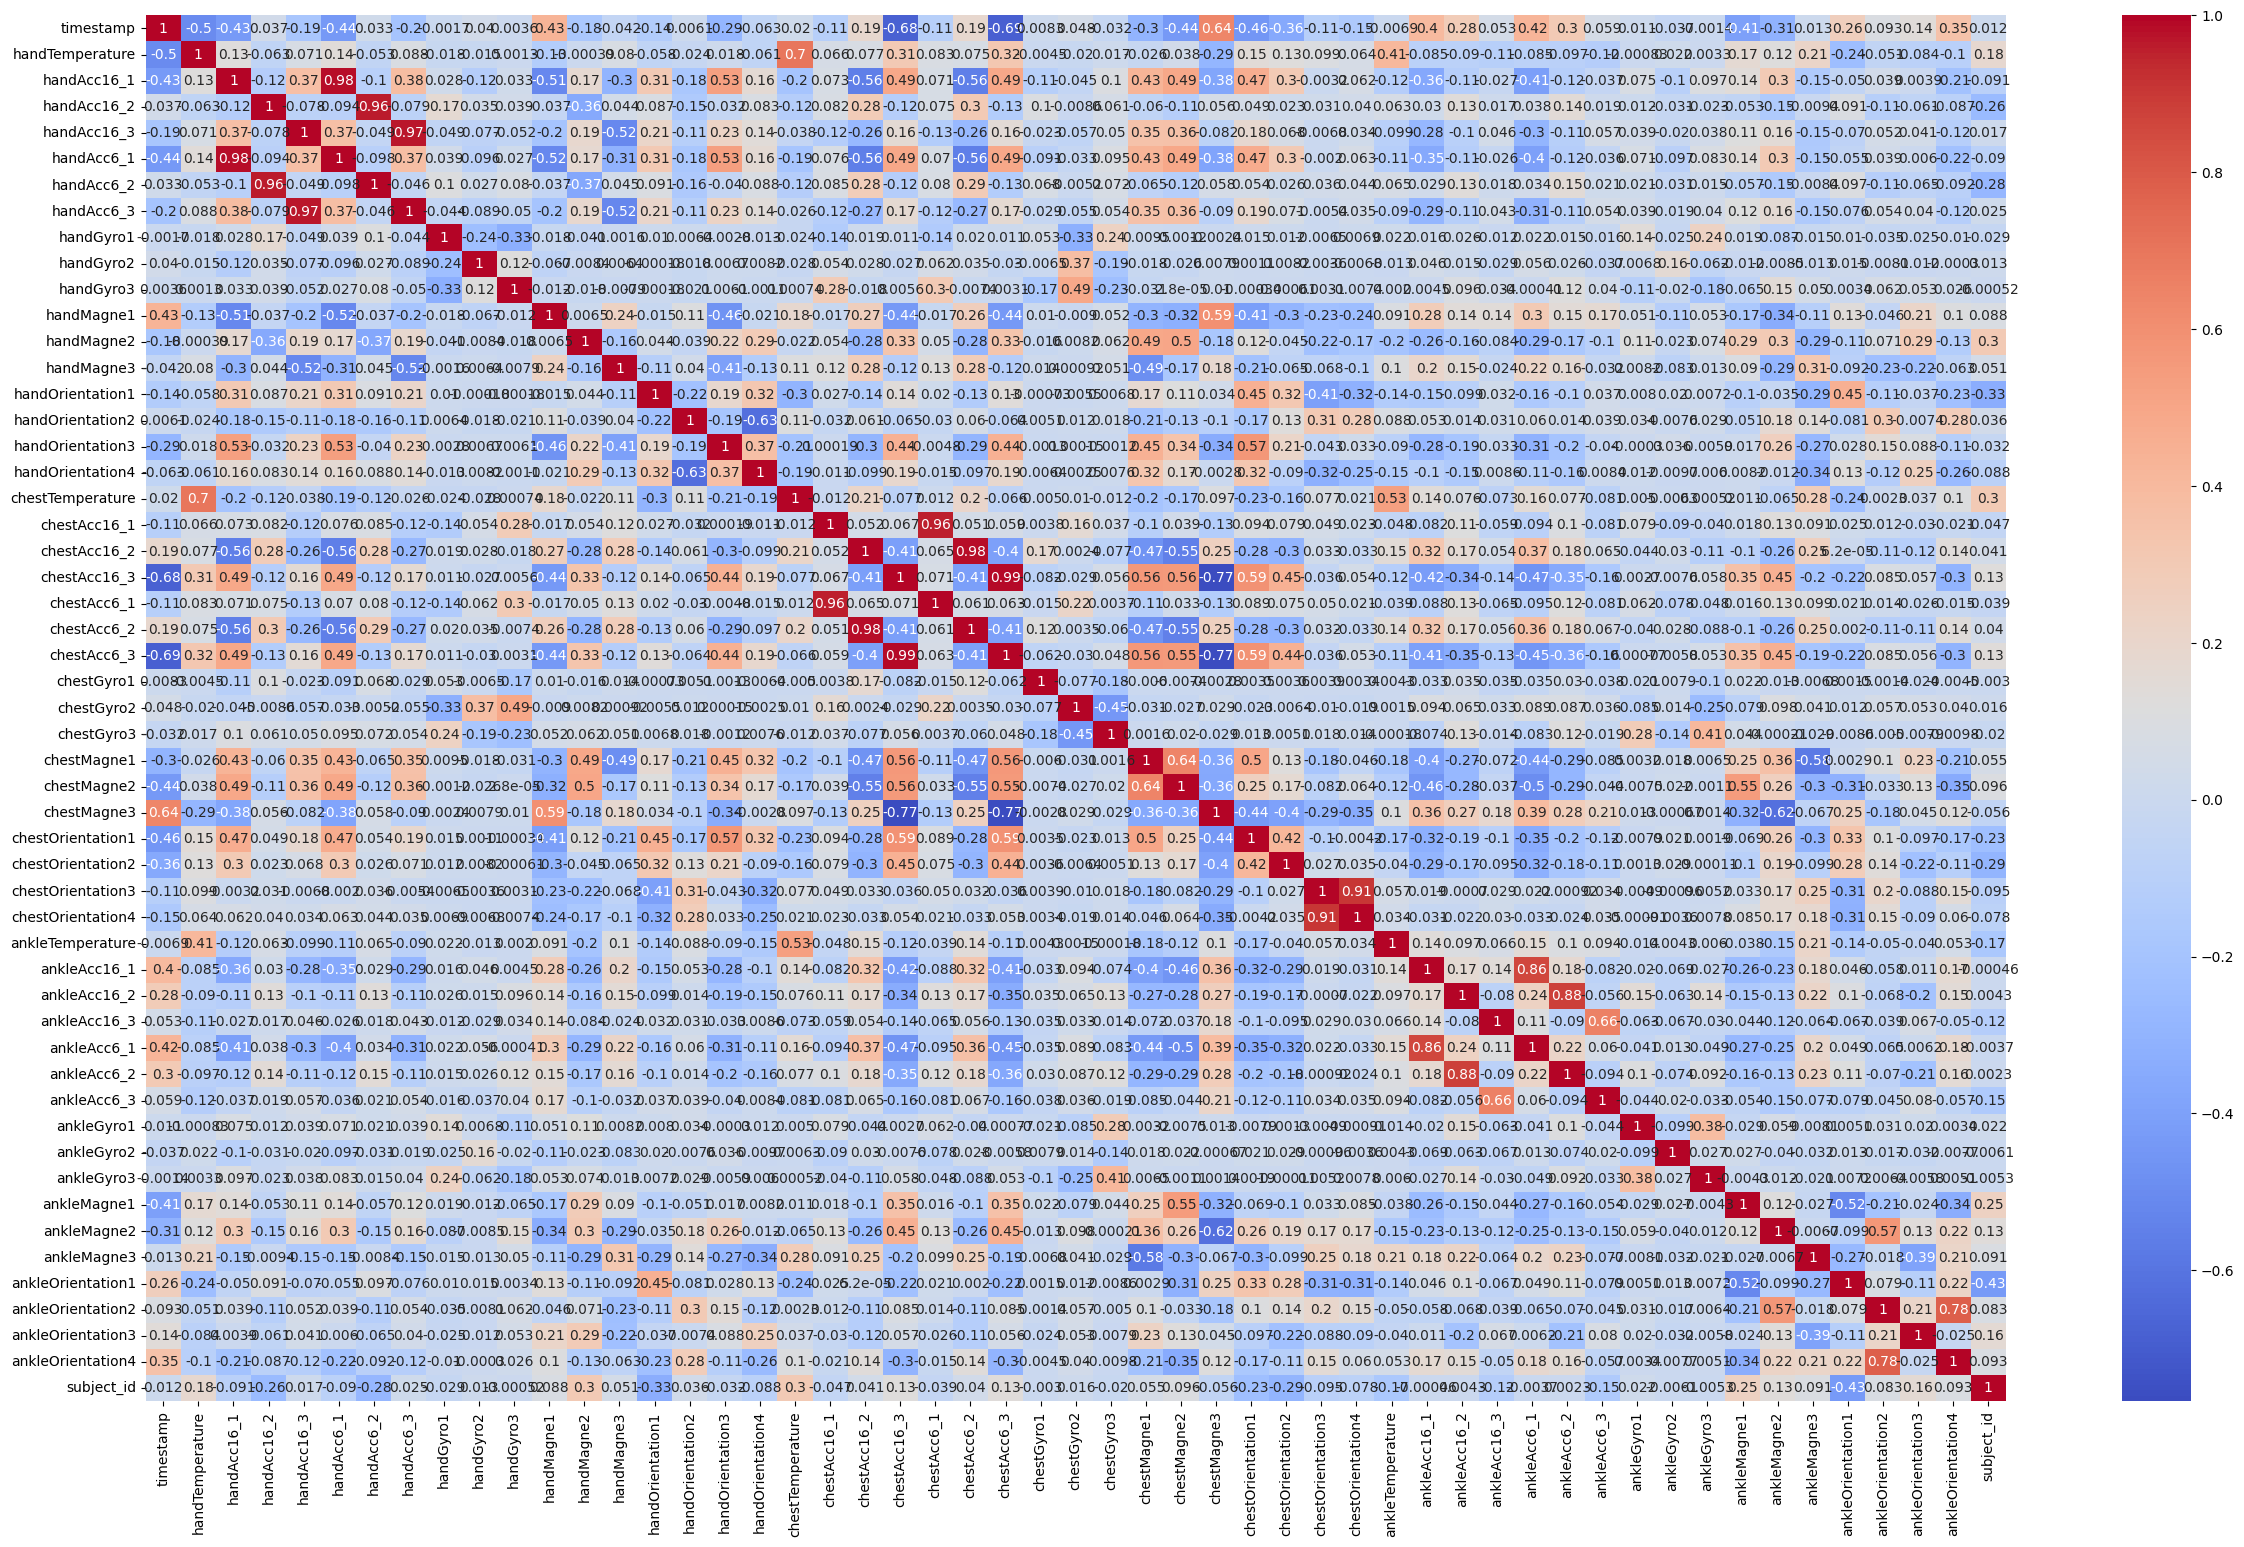

In [20]:
# Тепловая карта корреляций
plt.figure(figsize = (30, 18))
sns.heatmap(df.corr(), annot = True, cmap = 'coolwarm')
plt.show()

In [28]:
# Сгруппируем признаки по датчикам и посчитаем обобщенные признаки

# Список компонентов для каждого датчика
sensor_components = {
    'hand': ['Acc16', 'Acc6', 'Gyro', 'Magne', 'Orientation'],
    'chest': ['Acc16', 'Acc6', 'Gyro', 'Magne', 'Orientation'],
    'ankle': ['Acc16', 'Acc6', 'Gyro', 'Magne', 'Orientation']
}

# Создаем обобщенные признаки (векторные величины)
for sensor in sensor_components:
    for component in sensor_components[sensor]:
        if component == 'Acc16' or component == 'Acc6':
            cols = [f'{sensor}{component}_{i}' for i in range(1, 4)]
        else:
            cols = [f'{sensor}{component}{i}' for i in range(1, 4)]
        df[f'{sensor.lower()}_{component.lower()}'] = np.sqrt(np.sum(df[cols]**2, axis=1))

In [29]:
# удаляем признаки, учтенные в длинах векторов
df = df.drop(
    columns = [
        'handAcc16_1','handAcc16_2','handAcc16_3','handAcc6_1','handAcc6_2','handAcc6_3',
        'handGyro1','handGyro2','handGyro3','handMagne1','handMagne2','handMagne3',
        'handOrientation1','handOrientation2','handOrientation3', 'handOrientation4', 'handTemperature',
        'chestAcc16_1','chestAcc16_2','chestAcc16_3','chestAcc6_1','chestAcc6_2','chestAcc6_3',
        'chestGyro1','chestGyro2','chestGyro3','chestMagne1','chestMagne2','chestMagne3',
        'chestOrientation1','chestOrientation2','chestOrientation3', 'chestOrientation4', 'chestTemperature',
        'ankleAcc16_1','ankleAcc16_2','ankleAcc16_3','ankleAcc6_1','ankleAcc6_2','ankleAcc6_3',
        'ankleGyro1','ankleGyro2','ankleGyro3','ankleMagne1','ankleMagne2','ankleMagne3',
        'ankleOrientation1','ankleOrientation2','ankleOrientation3', 'ankleOrientation4', 'ankleTemperature'
    ]
)

In [30]:
# результат
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534601 entries, 0 to 534600
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   timestamp          534601 non-null  float64
 1   subject_id         534601 non-null  int64  
 2   hand_acc16         534601 non-null  float64
 3   hand_acc6          534601 non-null  float64
 4   hand_gyro          534601 non-null  float64
 5   hand_magne         534601 non-null  float64
 6   hand_orientation   534601 non-null  float64
 7   chest_acc16        534601 non-null  float64
 8   chest_acc6         534601 non-null  float64
 9   chest_gyro         534601 non-null  float64
 10  chest_magne        534601 non-null  float64
 11  chest_orientation  534601 non-null  float64
 12  ankle_acc16        534601 non-null  float64
 13  ankle_acc6         534601 non-null  float64
 14  ankle_gyro         534601 non-null  float64
 15  ankle_magne        534601 non-null  float64
 16  an

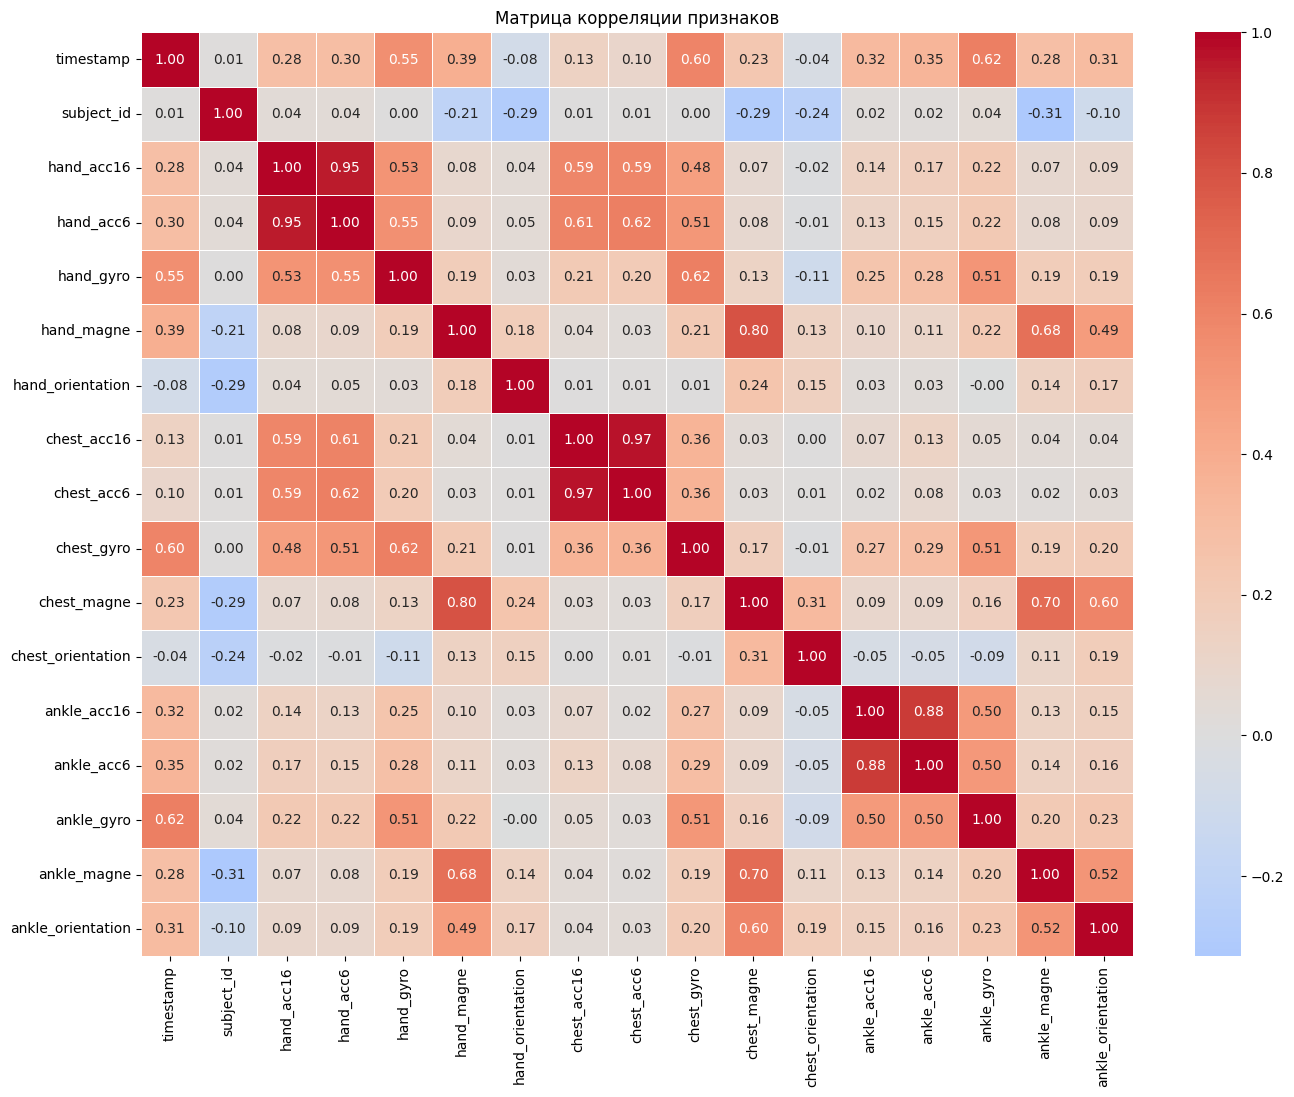

In [31]:
# Вычисляем матрицу корреляции для поулченных 17 признаков
corr_matrix = df.select_dtypes(include=['float64', 'int64']).corr()

plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            center=0, linewidths=0.5)
plt.title("Матрица корреляции признаков")
plt.show()

In [36]:
# Проанализируем есть ли мультиколлинераность и отберем признаки

threshold = 0.9

high_corr = (corr_matrix.abs()
             .stack()
             .reset_index()
             .rename(columns={0: 'corr'}))

high_corr = high_corr[high_corr['level_0'] != high_corr['level_1']]
high_corr = high_corr[high_corr['corr'] > threshold].sort_values('corr', ascending=False)

print("Пары признаков с высокой коллинеарностью\n")
print(high_corr)

Пары признаков с высокой коллинеарностью

         level_0      level_1      corr
143   chest_acc6  chest_acc16  0.967814
127  chest_acc16   chest_acc6  0.967814
53     hand_acc6   hand_acc16  0.950046
37    hand_acc16    hand_acc6  0.950046


'hand_acc6 ', 'chest_acc6' удалим, и оставим 'hand_acc16 ', 'chest_acc16'

In [38]:
df_cleaned = df.drop(columns=['hand_acc6', 'chest_acc6'])

In [39]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534601 entries, 0 to 534600
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   timestamp          534601 non-null  float64
 1   subject_id         534601 non-null  int64  
 2   hand_acc16         534601 non-null  float64
 3   hand_gyro          534601 non-null  float64
 4   hand_magne         534601 non-null  float64
 5   hand_orientation   534601 non-null  float64
 6   chest_acc16        534601 non-null  float64
 7   chest_gyro         534601 non-null  float64
 8   chest_magne        534601 non-null  float64
 9   chest_orientation  534601 non-null  float64
 10  ankle_acc16        534601 non-null  float64
 11  ankle_acc6         534601 non-null  float64
 12  ankle_gyro         534601 non-null  float64
 13  ankle_magne        534601 non-null  float64
 14  ankle_orientation  534601 non-null  float64
dtypes: float64(14), int64(1)
memory usage: 61.2 MB


### Обучение нескольких моделей, подбор гиперпараметров, их сравнение и выбор лучшей

In [40]:
# Создадим вектор признаков
X = df_cleaned.iloc[:, 1:]
X

,subject_id,hand_acc16,hand_gyro,hand_magne,hand_orientation,chest_acc16,chest_gyro,chest_magne,chest_orientation,ankle_acc16,ankle_acc6,ankle_gyro,ankle_magne,ankle_orientation
0,5,9.635277,0.022347,34.425872,0.702083,9.476392,0.039630,48.756258,0.991053,10.130236,9.819462,0.059178,31.494810,0.863907
1,2,9.963104,0.393683,55.213200,0.939875,12.175270,0.475300,43.098251,0.999699,6.958333,8.182519,1.934298,36.441815,0.905760
2,8,9.839886,0.048141,29.232354,0.862448,9.816755,0.041782,26.697400,0.995598,9.990753,9.828768,0.066698,35.493509,0.795224
3,2,14.524775,2.508222,49.067975,0.890322,12.559313,0.504263,39.066927,0.938479,14.122803,18.410660,4.589847,48.480489,0.938575
4,6,9.717695,0.034214,30.426190,0.917108,9.779122,0.063361,26.316878,0.996679,9.957803,9.869706,0.031659,21.283705,0.808274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534596,5,10.629118,4.439972,43.590911,0.729815,12.620551,2.130969,37.842988,0.944463,22.912390,24.519167,1.180975,41.689909,0.950166
534597,5,7.899791,0.043794,35.302914,0.591796,12.290140,0.790134,41.034572,0.825947,18.156183,13.818043,3.880268,50.553846,0.874404
534598,5,7.127962,2.006605,65.638750,0.664540,4.601540,0.533880,60.543222,0.991336,9.800323,9.549536,0.844063,53.802212,0.988396
534599,6,14.868625,4.491072,50.628692,0.924112,38.093478,1.742387,46.340162,0.863286,5.637294,33.075838,6.556362,53.557214,0.803122


Обучим модель KMeans и подберем гиперпараметры

Возьмем случайную выборку 10% данных, сохранив соотношение количества сэмплов между субъектами, т.к. данные не равномерно распределены

In [47]:
sample = X.groupby('subject_id').apply(lambda x: x.sample(frac=0.1, random_state=42)).reset_index(drop=True)

sample['subject_id'].value_counts()

,count
subject_id,
5,7679
8,7305
6,7024
1,6988
2,6874
4,6374
7,6212
3,5004


Метод локтя (Elbow Method)

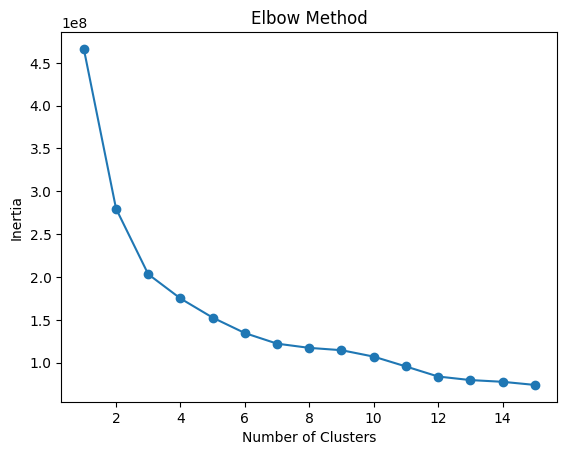

In [44]:
# Подберем оптимальное число кластеров
inertia = []
k_values = range(1, 16)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_) # inertia_ -- сумма квадратов расстояний точек до центроидов

# Строим график метода локтя
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

По графику кажется оптимально k=3

Метод силуэта (Silhouette Score)

In [50]:
%%time
for i in [2, 3, 4, 5, 6]:
    # инициализируем алгоритм с соответствующим количеством кластеров
    kmeans = KMeans(n_clusters=i, random_state=42)

    # обучаем модель и получаем кластеры
    kmeans.fit(sample)
    clusters_kmean = kmeans.predict(sample)

    # считаем оценку
    score = silhouette_score(sample, clusters_kmean)
    # и выводим ее в консоль
    print(f'Score KMeans for K={i}: {score}')

Score KMeans for K=2: 0.47405791199912845
Score KMeans for K=3: 0.3359337251660279
Score KMeans for K=4: 0.3163046696069434
Score KMeans for K=5: 0.33521663733197393
Score KMeans for K=6: 0.3068056863345439
CPU times: user 2min 58s, sys: 41.7 s, total: 3min 39s
Wall time: 3min 3s


2 не подходит по методу локтя, а 3 и 5 имеют близкие значения скора силуэта

In [51]:
#  попробуем посмотреть на выборке из 20 процентов случайных данных датасета
sample2 = X.groupby('subject_id').apply(lambda x: x.sample(frac=0.2, random_state=42)).reset_index(drop=True)

sample2['subject_id'].value_counts()

,count
subject_id,
5,15359
8,14609
6,14048
1,13976
2,13748
4,12748
7,12423
3,10009


In [ ]:
# 15 минут

In [54]:
for i in [2, 3, 4, 5, 6]:
    # инициализируем алгоритм с соответствующим количеством кластеров
    kmeans = KMeans(n_clusters=i, random_state=42)

    # обучаем модель и получаем кластеры
    kmeans.fit(sample2)
    clusters_kmean = kmeans.predict(sample2)

    # считаем оценку
    score = silhouette_score(sample2, clusters_kmean)
    # и выводим ее в консоль
    print(f'Score KMeans for K={i}: {score}')

Score KMeans for K=2: 0.3566500376318766
Score KMeans for K=3: 0.3351754676005794
Score KMeans for K=4: 0.314789875859894
Score KMeans for K=5: 0.3342694914767158
Score KMeans for K=6: 0.33783246449869414


 При K=3 (0.335)значение скора больше, чем при K=5 (0.334)

In [55]:
%%time
# Обучаем модель с оптимальным K
k_opt = 3

X = X.drop(columns=['subject_id'])

kmeans = KMeans(n_clusters=k_opt, random_state=42)
X['cluster'] = kmeans.fit_predict(X)

CPU times: user 830 ms, sys: 71.2 ms, total: 901 ms
Wall time: 891 ms


In [56]:
X['cluster'].shape

(534601,)

Теперь нам нужно перенумеровать классы в порядке их появления:

пример: 3 3 4 5 3 2 1 3 -> 0 0 1 2 0 3 4 0

и создать файл submission

In [57]:
X['activityID'] = -1
unique_clusters = sorted(X['cluster'].unique())
for label, prev_label in enumerate(unique_clusters, start=1):
    X.loc[X['cluster'] == prev_label, 'activityID'] = label

submission = X[['activityID']].reset_index()
submission.columns = ['Index', 'activityID']
submission.to_csv('submission.csv', index=False)

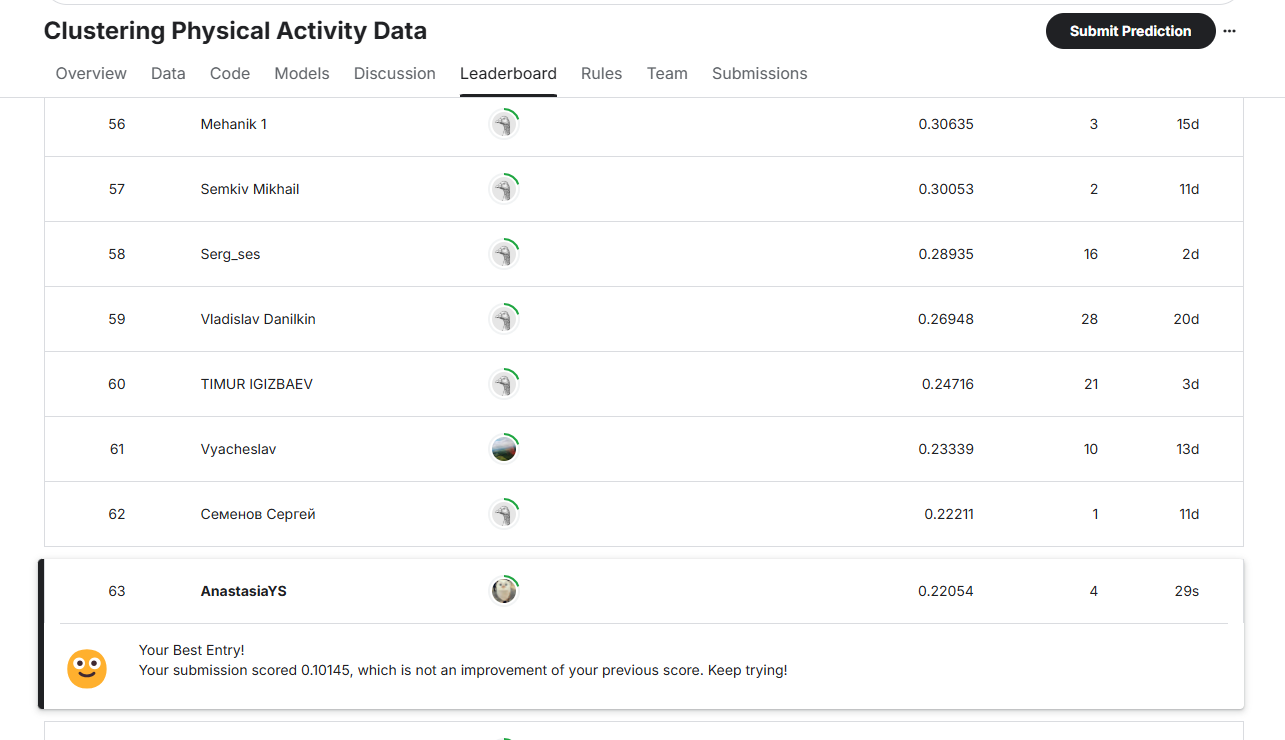